In [1]:
cd ..

/Users/SP/code/spectralCV


In [2]:
%matplotlib inline

# imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

import neurodsp as ndsp
from scv_funcs import lfpca
from scv_funcs import utils

CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)

In [ ]:
from bokeh.plotting import figure, output_file, save
output_file("kjm_bp.html")

In [3]:
# electrode location
elec_def = {
    '1': 'dorsal M1',
    '3': 'dorsal S1',
    '4': 'ventral S1+M1',
    '6': 'frontal (non-R)',
    '7': 'parietal (non-R)',
    '8': 'temporal',
    '9': 'occipital'
}
fs = 1000.

In [4]:
from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from scipy.stats import expon
output_notebook()

Loading BokehJS ...

In [5]:
cd results/kjm_digits/bp/

/Users/SP/code/spectralCV/results/kjm_digits/bp


In [6]:
trial_data = np.load('trial_info.npz')

In [7]:
trial_info = trial_data['trial_info']
elec_regions = trial_data['elec_regions']

In [8]:
lfpca_all = []
lfpca_all.append(lfpca.lfpca_load_spec('pre.npz'))
lf = lfpca_all[0]

In [ ]:
chan_sel = []
for plot_chan in range(lf.numchan):
    try:
        ele_name = elec_def[elec_regions[plot_chan].astype(str)]
    except:
        ele_name = 'others'
    chan_sel.append('%i: '%plot_chan+ele_name)
    
def update_spct_hist(x, y, f=10, channel=0, numbins=20):
    plot_chan = int(channel.split(':')[0])
    plot_freq = np.where(lf.f_axis==f)[0][0]
    y, x = np.histogram(lf.spg[plot_chan,plot_freq,:], bins=numbins, density=True)
    # update histogram with data from frequency f
    hist_plot.data_source.data['left'] = x[:-1]
    hist_plot.data_source.data['right'] = x[1:]
    hist_plot.data_source.data['top'] = y    
    # update fitted
    rv = expon(scale=sp.stats.expon.fit(lf.spg[plot_chan,plot_freq,:],floc=0)[1])
    fit_plot.data_source.data['x'] = x
    fit_plot.data_source.data['y'] = rv.pdf(x)
    
    hist_fig.title.text = elec_def[elec_regions[plot_chan].astype(str)] + ': f=%.1fHz, p=%.4f '%(f,lf.ks_pvals[plot_chan,plot_freq])
    push_notebook()

In [ ]:
y, x = np.histogram(lf.spg[0,10,:], bins=20, density=True)
hist_fig = figure(plot_height=400, plot_width=400, x_axis_label='Power', y_axis_label='Probability',background_fill_color="#E8DDCB")
hist_plot = hist_fig.quad(top=y, bottom=0, left=x[:-1], right=x[1:], fill_color="#036564", line_color="#033649")
fit_plot = hist_fig.line(x[:-1],y, line_width=8,alpha=0.7,line_color="#D95B43",legend='Fit PDF')
show(hist_fig, notebook_handle=True)
interact(update_spct_hist, x=x, y=y, f=(1,100), numbins=(10,55,5), channel=chan_sel)

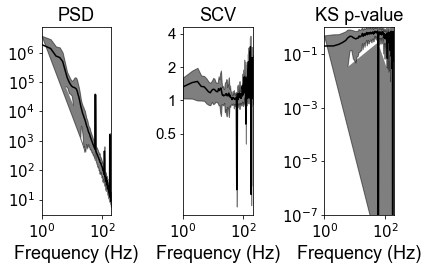

In [9]:
lf.plot_spectral()

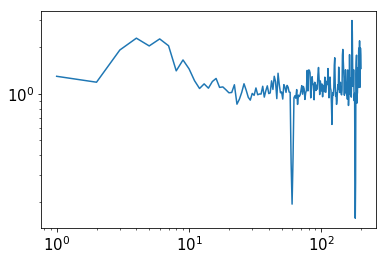

In [10]:
plt.loglog(lf.f_axis,lf.scv[0].T)

/Users/SP/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


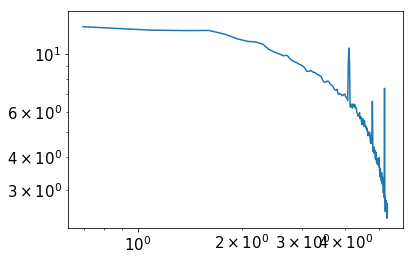

In [11]:
# plotting psd
plt.loglog(np.log(lf.f_axis),np.log(lf.psd[0].T))

In [12]:
lf.f_axis[1:]

array([   1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,    9.,
         10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,   18.,
         19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,   27.,
         28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,   36.,
         37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,   45.,
         46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,   54.,
         55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,   63.,
         64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,   72.,
         73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,   81.,
         82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,   90.,
         91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,   99.,
        100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,  108.,
        109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,  117.,
        118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,  126.,
        127.,  128.,

In [18]:
from bokeh.io import output_file, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.models.widgets import PreText, Select
from bokeh.io import curdoc
from bokeh.layouts import row, column

chan_count, freq = lf.psd.shape

DEFAULT_TICKERS = list(map(str, range(chan_count)))
ticker = Select(value='0', title='channel', options=DEFAULT_TICKERS)

x = np.log(lf.f_axis[1:])
y0 = np.log(lf.psd[1].T[1:])
y1 = np.log(lf.scv[1].T[1:])

# create a column data source for the plots to share
source = ColumnDataSource(data=dict(x=x, y0=y0, y1=y1))

TOOLS = "box_select,lasso_select,help"

left = figure(tools=TOOLS, plot_width=300, plot_height=300, title='PSD')
right = figure(tools=TOOLS, plot_width=300, plot_height=300, title='SCV')

def left_psd_plot(source):
    # create a new plot and add a renderer
    left.line('x', 'y0', source=source, color='navy')
    left.circle('x', 'y0', source=source, size=4, color='darkgrey', alpha=0.2)
    left.legend.location = 'top_left'
    left.xaxis.axis_label = 'Frequency (Hz)'
    left.yaxis.axis_label = 'Power/Frequency (dB/Hz)'
    left.grid.grid_line_alpha=0.3

def right_scv_plot(source):
    # create another new plot and add a renderer
    right.line('x', 'y1', source=source, color='navy')
    right.circle('x', 'y1', source=source, size=4, color='darkgrey', alpha=0.2)
    right.legend.location='top_left'
    right.xaxis.axis_label = 'Frequency (Hz)'
    right.yaxis.axis_label = 'Unitless'
    right.grid.grid_line_alpha=0.3

def selection_change(attr, old, new):
    left = left
    right = right
    chan = int(ticker.value)
    x = np.log(lf.f_axis[1:])
    y0 = np.log(lf.psd[chan].T[1:])
    y1 = np.log(lf.scv[chan].T[1:])
    data = dict(x=x, y0=y0, y1=y1)
    # create a column data source for the plots to share
    source.data = data
    left_psd_plot(source=data)
    right_scv_plot(source=data)

left_psd_plot(source)
right_scv_plot(source)
p = gridplot([[left, right]], plot_width=400, plot_height=400)

ticker.on_change('value', selection_change)

widgets = column(ticker)
main_row = row(widgets)
layout = column(main_row, p)

# show(widgetbox(select))
curdoc().add_root(layout)

show(layout)

In [ ]:
int('44')

In [ ]:
interact(update_spct_hist, f=(1,100), numbins=(10,55,5), channel=chan_sel)

In [ ]:
type(range(10,15))